# Twitter Text Content Analysis

## 1. Initialize a spark context

In [1]:
import pixiedust
pixiedust.enableJobMonitor()
sc = pixiedust.sc
sc

Pixiedust database opened successfully


Unable to check latest version <urlopen error [Errno -3] Temporary failure in name resolution>
Succesfully enabled Spark Job Progress Monitor


<SparkContext master=local[10] appName=pyspark-shell>

## 2. Load the data, process it and compute the similarity vectors between the tweets

In [75]:
import csv
import requests,os,re
import pandas as pd
from itertools import groupby
from math import log10, sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.ml.linalg import Vectors
from numpy import array, dot, isnan
from numpy.linalg import norm


#1 Download the data from the dropbox link
def download_file(url, location):
    filename = os.path.join(location, url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: 
                f.write(chunk)
    return filename

url = "https://www.dropbox.com/s/jsoi0v9rb52w6du/pd_tweets_df.csv?dl=1"
location = ''
#2 file = download_file(url, location)
file = 'pd_tweets_df.csv'

#3 Load the csv data as a panda dataframe
tweets_df = pd.read_csv(location + file)

#4 Create rdd of the text of every tweet
tweetrdd =  sc.parallelize(tweets_df['text:'], 10)\
              .filter(lambda x: type(x) == str)\
              .map(lambda tweet: re.sub(('\n'), '', tweet))\
              .map(lambda tweet: tweet.split(' @ ', )[0])\
              .map(lambda tweetwords: re.sub('https?', '', tweetwords))\

#5 Set the n_oftweets to analyze and create a subset rdd out of the original tweet texts
n_oftweets = 750
tweetrddsubset = sc.parallelize(tweetrdd.take(n_oftweets))

#6 Partition the tweetrdd into a list of words per individual tweet and filter out the special characters&stopwords
stopwords = ["ourselves", "hers", "between", "yourself", "but", "again", "there", "about", "once", "during", "out", "very", "having", "with", "they", "own", "an", "be", "some", "for", "do", "its", "yours", "such", "into", "of", "most", "itself", "other", "off", "is", "s", "am", "or", "who", "as", "from", "him", "each", "the", "themselves", "until", "below", "are", "we", "these", "your", "his", "through", "don", "nor", "me", "were", "her", "more", "himself", "this", "down", "should", "our", "their", "while", "above", "both", "up", "to", "ours", "had", "she", "all", "no", "when", "at", "any", "before", "them", "same", "and", "been", "have", "in", "will", "on", "does", "yourselves", "then", "that", "because", "what", "over", "why", "so", "can", "did", "not", "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only", "myself", "which", "those", "i", "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", "a", "by", "doing", "it", "how", "further", "was", "here", "than"]
wordrdd_tweet = tweetrddsubset.map(lambda line: [re.findall('\w*', word.lower())[0] for word in line.split(' ')] )\
                        .map(lambda tweet: list(filter(lambda tweet: tweet is not '', tweet)))\
                        .map(lambda wordlist: [word for word in wordlist if word not in stopwords])
            
#7 Costruct the rdd of all words of all tweets together
wordrdd = tweetrddsubset.flatMap(lambda line: line.split())\
                  .map(lambda word: word.lower())\
                  .map(lambda word: re.findall('\w*' , word)[0])\
                  .filter(lambda word: word is not '')

#8 count the number of words as a summary statistic
total_wordcount = wordrdd.count()

#9 Count the number of times the word repeats within the same tweet for all tweets
countedwordpairrdd_tweet = wordrdd_tweet.map(lambda tweet: sorted(tweet))\
                                    .map(lambda tweetsorted: [(word,len(list(n))) for word,n in groupby(tweetsorted)])

#10 Calculate the term frequency (TF) per tweet as RDD 
tf_tweet = countedwordpairrdd_tweet.map(lambda wordpair: [(word, n/len(wordpair)) for word, n in wordpair])

#11 Create a unique word rdd and count the number of words as a summary statistic
wordrdd_unique = wordrdd.map(lambda word: (word,1))\
                        .reduceByKey(lambda key, next_key : key + next_key)\
                        .map(lambda wordpair: wordpair[0])

n_uniquewords = wordrdd_unique.count()

#12 Convert&collect uniquewordrdd to K-V pair list with zeros to append to every tweet to equalize tweetsize later on
uniquewordvector_withzeros = wordrdd_unique.map(lambda word: (word, 0)).collect()

#13 Remove duplicate words per tweet and count total number of tweets each word occurs in
idf  = countedwordpairrdd_tweet.map(lambda tweet: [(word, 1) for word,n in tweet])\
                               .flatMap(lambda tweet: tweet)\
                               .reduceByKey(lambda value_so_far, next_value : value_so_far + next_value)\
                               .map(lambda wordpair: (wordpair[0], log10(n_oftweets/wordpair[1])))              

#14 Collect the IDF of all unique words as a dictionary
idfdict = idf.collectAsMap()

#15 Create TFIDF by multiplying TF of every word per tweet with the lookedup IDF value from the IDF dictionary above
tfidf_word_tweet = tf_tweet.map(lambda wordpair: [ (word, tf*idfdict[word]) for word,tf in wordpair ] )

#16 Equalize every tweet's length by inserting missing unique wordpairs created in step #12, zip result with index
total_indexedtfidfmatrix = tfidf_word_tweet.map(lambda tweetwordpairs: tweetwordpairs + list(filter(lambda word: word[0] not in [word for word, tfidf in tweetwordpairs], uniquewordvector_withzeros)))\
                                           .map(lambda tweet: sorted(tweet, key=lambda x: x[0]))\
                                           .map(lambda wordvector: [tfidf for word, tfidf in wordvector])\
                                           .map(lambda tfidfvector: Vectors.dense([tfidf for tfidf in tfidfvector]))\
                                           .zipWithIndex()      

# 17 Create a matrix that uses the cartesian product between every tweet to construct tweet comparison containers.
# Then compute the cosine dissimilarity between every such container to get a measure of distance between each tweet 
dissimilarity_rdd = total_indexedtfidfmatrix.cartesian(total_indexedtfidfmatrix)\
                                            .sortBy(lambda pairof_vectorindexpairs: (pairof_vectorindexpairs[0][1],  pairof_vectorindexpairs[1][1]) )\
                                            .map(lambda pairof_vectorindexpairs: (1-(pairof_vectorindexpairs[0][0].dot(pairof_vectorindexpairs[1][0])/(pairof_vectorindexpairs[0][0].norm(2)*pairof_vectorindexpairs[1][0].norm(2))),  (pairof_vectorindexpairs[0][1], pairof_vectorindexpairs[1][1]) ))\
                                            .map(lambda tweetsimilaritypair: (1.0, tweetsimilaritypair[1]) if isnan(tweetsimilaritypair[0]) else tweetsimilaritypair)

# 18 Compartamentalize every entry of the dissimilarityrdd per tweet to construct indexed matrix that compares each                   
# tweet with every other tweet (watch out this results in a very LARGE MATRIX!)
dissimilarity_matrix = dissimilarity_rdd.groupBy(lambda x: x[1][0])\
                                        .map(lambda tweetvsrest: list(tweetvsrest[1]))
    
    
# Print summary of totals with line below
print('total words:', total_wordcount, ', unique words:', n_uniquewords, ', number of tweets:', n_oftweets)

total words: 6976 , unique words: 1874 , number of tweets: 750


## 3. Cluster and plot the tweet similarity vector matrix with K-Means with different parameters

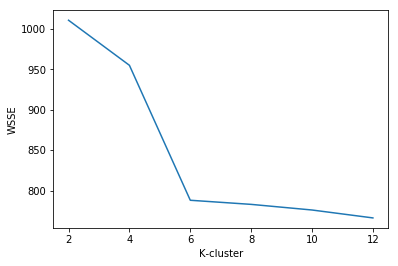

In [76]:
import matplotlib.pyplot as plt
import random
from pyspark.mllib.clustering import KMeans, KMeansModel
# Build the model (cluster the data)
#1 Load Data 
Data = dissimilarity_matrix.map(lambda similarityvector: array([similarityentry[0] for similarityentry in similarityvector]))

#2 Fit model with different cluster sizes and compute the costs
WSSE_all = []
k = range(2,14,2)

# Function used in calculating costs by computing Within Set Sum of Squared Errors
def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

for i in k:
    model = KMeans.train(Data, i, maxIterations=15, initializationMode="k-means")
    WSSE = Data.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    WSSE_all = WSSE_all+[WSSE]

#3 Plot the results
plt.plot(k,WSSE_all)
plt.ylabel('WSSE')
plt.xlabel('K-cluster')
plt.show()




## 4. Find optimal model (experimental)

In [77]:
#4 Calculate optimal k by setting the cost threshold as low as possible
threshold = 15

#index = []
#for i in range(len(WSSE_all)-1):
#    if (WSSE_all[i]-WSSE_all[i+1]) < threshold:
#        index +=[i]
#    index_final = index[0]
#k_final = k[index_final]

k_final = 6

print('perfect k is :',k_final)

final_model = KMeans.train(Data, k_final, maxIterations=15, initializationMode="k-means")
centers = final_model.centers
WSSEfinal = Data.map(lambda point: error(point)).reduce(lambda x, y: x + y)

# Print the final result
print('WSSE = ', WSSEfinal)

perfect k is : 6
WSSE =  766.1526337630685


## 5. Couple all tweets with cluster and analyze the TFIDF for every word that falls in a cluster. Then, retrieve the top 10 distinctive words for each cluster.

In [95]:
# 0 Create tweetclusterindices
tweetclusterindices = Data.zipWithIndex()\
                          .map(lambda pair: (pair[1], final_model.predict(pair[0])))\
                          .collect()

# 1 Merge all tweets in cluster
words_clusterrdd = wordrdd_tweet.map(lambda cluster: ' '.join(cluster))\
                                 .zipWithIndex()\
                                 .map(lambda pair: (pair[0], tweetclusterindices[pair[1]]))\
                                 .map(lambda pair: (pair[0], pair[1][1]))\
                                 .groupBy(lambda pair: pair[1])\
                                 .map(lambda pair: list(pair[1]))\
                                 .map(lambda cluster: [pair[0] for pair in cluster])\
                                 .map(lambda cluster: [' '.join(cluster)])\
                                 .map(lambda cluster: cluster[0].split())
# 2 Count word pair                                  
countedwordpairrdd_cluster = words_clusterrdd.map(lambda tweet: sorted(tweet))\
                                    .map(lambda tweetsorted: [(word,len(list(n))) for word,n in groupby(tweetsorted)])

#3 Calculate the term frequency (TF) per cluster
tf_cluster = countedwordpairrdd_cluster.map(lambda wordpair: [(word, n/len(wordpair)) for word, n in wordpair])

#4 Remove duplicate words per cluster and count total number of clusters each word occurs in
idf_cluster  = countedwordpairrdd_cluster.map(lambda tweet: [(word, 1) for word,n in tweet])\
                               .flatMap(lambda tweet: tweet)\
                               .reduceByKey(lambda value_so_far, next_value : value_so_far + next_value)\
                               .map(lambda wordpair: (wordpair[0], log10(k_final/wordpair[1]))) 

#5 Collect the IDF of all unique words as a dictionary
idfdictcluster = idf.collectAsMap()

#6 Create TFIDF by multiplying TF of every word per cluster with the IDF value from the IDF dictionary above
tfidf_word_cluster = tf_cluster.map(lambda wordpair: [ (word, tf*idfdictcluster[word]) for word,tf in wordpair ] )

#7 Get representatitve words per cluster (tf and tfidf)
sortedtfidf_word_cluster = tfidf_word_cluster.map(lambda cluster: [b for a,b in sorted((-tup[1], tup) for tup in cluster)] )
sortedtf_word_cluster = tf_cluster.map(lambda cluster: [b for a,b in sorted((-tup[1], tup) for tup in cluster)] )

#8 Get representatitve words per cluster
tfidf_representative_words_cluster = [sortedtfidf_word_cluster.collect()[index][:10] for index in range(k_final)]
toptfidf_representative_words_cluster = list(map(lambda x: [y[0] for y  in x], tfidf_representative_words_cluster))

tf_representative_words_cluster = [sortedtf_word_cluster.collect()[index][:10] for index in range(k_final)]
toptf_representative_words_cluster = list(map(lambda x: [y[0] for y  in x], tf_representative_words_cluster))

print('Most representative words for each cluster with TFIDF:')
number = 0
for cluster in toptfidf_representative_words_cluster:
    print (number, cluster)
    number += 1

print('\n')
    
print('Most representative words for each cluster with TF:')
number2 = 0
for cluster in toptf_representative_words_cluster:
    print (number2, cluster)
    number2 += 1

Most representative words for each cluster with TFIDF:
0 ['co', 'colorado', 'day', 'love', 'inch', 'like', 'reports', 'get', 'one', 'new']
1 ['co', 'rain', '8', 'heavy', 'beautiful', 'one', '2005', 'absolute', 'arrowhead', 'binghi']
2 ['stay', 'view', 'driving', 'colorado', 'mountain', 'posted', '8th', 'ancient', 'apparel', 'backyard']
3 ['today', 'see', 'work', 'kingdom', 'wazdown', 'rest', 'beauty', 'tour', 'good', 'start']
4 ['made', 'anejo', 'baxendale', 'bella', 'blueskyhomegroup8187', 'career', 'chillaxing', 'estate', 'extra', 'golden']
5 ['favorite', 'watching', 'yet', 'co', 'great', 'back', 'morning', 'new', 'andrews', 'beneficial']


Most representative words for each cluster with TF:
0 ['co', 'colorado', 'day', 'inch', 'like', 'love', 'reports', 'get', 'one', 'beautiful']
1 ['co', '8', 'beautiful', 'heavy', 'inch', 'one', 'rain', 'reports', '0', '2']
2 ['colorado', 'driving', 'mountain', 'photo', 'posted', 'stay', 'view', '6', '7', '8th']
3 ['today', 'good', 'kingdom', 'rest'

## 6. Create a Histogram of all the clusters

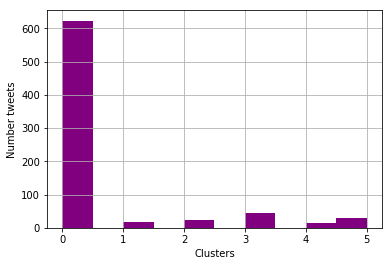

In [79]:
import matplotlib.mlab as mlab

#GET THE HISTOGRAM WITH THIS
tweets_cluster_plot =  list(map(lambda pair: pair[1], tweetclusterindices))

# the histogram of the data
plt.hist(tweets_cluster_plot, facecolor='purple')

plt.xlabel('Clusters')
plt.ylabel('Number tweets')
#plt.axis([0, 10, 0, 10])
plt.grid(True)

plt.show()


